In [1]:
import os
import json
import pandas as pd

In [2]:
files = os.listdir('logs')
log_files = [ f for f in files if f != ".gitignore" ]
log_files[:2]

['ReFAct-ab208055-1c82-4afb-a7ed-96356bfb9c9b.json',
 'ReFAct-f4de6a68-fc6c-48be-bba7-98ec9bc21217.json']

# Analyse the logs

The ReFAct agent comes with a number of configuration settings:

In [11]:
log_file = json.load(open('logs/' + log_files[0]))
config_settings = list(log_file['agent_settings'].keys())
config_settings

['consider_cyclomatic_complexity',
 'make_incremental_changes',
 'use_refactoring_tricks',
 'get_buddy_feedback',
 'use_previous_history',
 'make_plan',
 'dynamic_plan',
 'modify_specific_method',
 'clear_error_after_n',
 'clip_context_window']

As a first experiment, the agent was run on a number of sample projects:

In [12]:
SAMPLE_PROJECTS_DIR = 'samples'
projects = os.listdir(SAMPLE_PROJECTS_DIR)
projects

['js_gilded_rose',
 'java_gilded_rose',
 'js_json_object',
 'java_tabula',
 'py_yahtzee',
 'java_tennis',
 'java_yahtzee',
 'py_tennis',
 'js_trivia']

Each config setting was enabled exactly once, with all other config settings disabled. This was executed for each sample project, resulting in the following number of agent logs:

In [17]:
len(projects) * len(config_settings) + len(projects)

99

In [125]:
# First, let's load all the logs. Result is a list of dictionaries
log_jsons = []
for log_file in log_files:
    with open(f"logs/{log_file}") as f:
        log_jsons.append(json.load(f))

# Create a dataframe from the list of dictionaries
df = pd.DataFrame(log_jsons)

# the 'execution' column is again a list of dictionaries,
# so we need to explode
df = df.explode("execution")
print("Rows, Cols:", df.shape)
df.head()

Rows, Cols: (3630, 4)


,agent_settings,execution,project,llm
0,"{'consider_cyclomatic_complexity': False, 'mak...",\n You are a professional software develope...,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'thought': 'First, I need to get an overview ...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'tool': 'browse_files', 'result': 'Files: ten...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...",{'thought': 'I should start by examining the m...,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'tool': 'open_file', 'result': '# -*- coding:...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o


In [126]:
# drop all rows where the execution doesn't parse to a dict

df = df[df["execution"].apply(lambda x: isinstance(x, dict))]
print("Rows, Cols:", df.shape)

# drop all rows where "tool" key is not present in the execution dictionary
df = df[df["execution"].apply(lambda x: "tool" in x)]

# we normalize the "agent_settings" column as well as the "execution" column,
# which both contain dictionaries

df_as_list = df.to_dict(orient="records")
df = pd.json_normalize(df_as_list)
print("Rows, Cols:", df.shape)

df.head(3)

Rows, Cols: (3484, 4)
Rows, Cols: (1677, 15)


,project,llm,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
0,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,browse_files,"Files: tennis.py, test_tennis.py, test_tennis_...",NaN
1,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,open_file,# -*- coding: utf-8 -*-\n\nclass TennisGameDef...,NaN
2,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,open_file,# -*- coding: utf-8 -*-\n\nimport pytest\nfrom...,NaN


Now that we've arranged our data, it's time to analyze it. Let's start with the number of commits as a first metric.

In [128]:
# select all columns where the execution.tool is "commit_changes"
df = df[df["execution.tool"] == "commit_changes"]
df[["execution.tool", "project"]].describe()

,execution.tool,project
count,215,215
unique,1,9
top,commit_changes,/Users/I539028/Desktop/Seminar/refactoring-lab...
freq,215,37


In [133]:
# finde the rows where all columns that start with "agent_settings" are set to False
df_all_settings_false = df[~df.filter(like="agent_settings").any(axis=1)]
df_all_settings_false.head(3)

,project,llm,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
42,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,Changes committed.,NaN
248,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,Changes committed.,NaN
370,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,No changes to commit for file src/main/java/Ya...,NaN


In [134]:
# get the number of rows where all columns that start with "agent_settings" are set to False
num_commits_all_disabled = len(df_all_settings_false)
num_commits_all_disabled

18

In [135]:
# lambda function to transform the snake_case to Upper Case With Spaces
snake_to_upper = lambda x: x.replace("_", " ").title()

In [137]:
# create a new df, with a row for each agent setting and the number of commits
df_commit_counts = pd.DataFrame()
for agent_setting in config_settings:
    df_commit_counts[agent_setting] = df[f"agent_settings.{agent_setting}"].value_counts().values
df_commit_counts

# apply the snake_to_upper function to the column names
df_commit_counts.columns = df_commit_counts.columns.map(snake_to_upper)

# transpose the dataframe, so that the agent settings are the columns
df_commit_counts = df_commit_counts.T

# drop the first column, since the second column is the number of commits
df_commit_counts = df_commit_counts.drop(df_commit_counts.columns[0], axis=1)
df_commit_counts.columns = ["Number of tested commits"]

# append a row with the number of commits where all agent settings are disabled
df_commit_counts.loc["No Settings Enabled"] = [num_commits_all_disabled]

# sort ascending
df_commit_counts = df_commit_counts.sort_values(by="Number of tested commits", ascending=True)
df_commit_counts

,Number of tested commits
Consider Cyclomatic Complexity,12
Make Incremental Changes,14
Get Buddy Feedback,15
Use Previous History,17
No Settings Enabled,18
Clip Context Window,19
Clear Error After N,20
Dynamic Plan,23
Use Refactoring Tricks,26
Modify Specific Method,33


In [139]:
# get the idx of "No Settings Enabled"
idx = df_commit_counts.index.get_loc("No Settings Enabled")
idx

4

Below is the first set of evaluation, showing the (individually) enabled agent settings and their effect on the number of successful commits.

<Axes: >

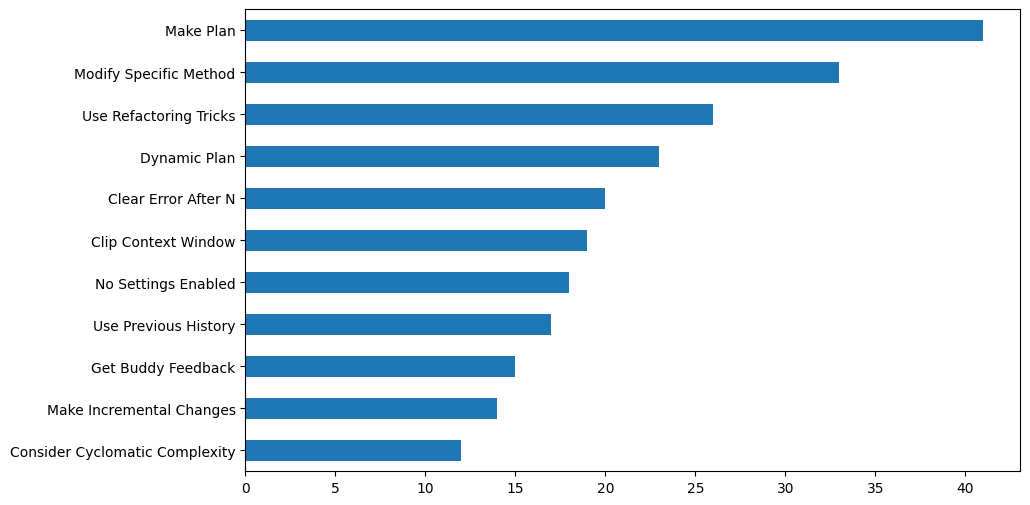

In [141]:
# display as a histogram
df_commit_counts.plot(kind="barh", legend=False, figsize=(10, 6))